## Imports

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from data_process.file_wrapper import FileWrapper
from data_process.utils import get_by_path
from data_process.syncer import Syncer
%matplotlib widget

## Load data

In [25]:
# pickle_file = '/home/ntkot/theses/ros/bag_db/rejected/data_15_09_2023__19_00_39/rosbag2_15_09_2023__19_00_39/rosbag2_15_09_2023__19_00_39.pkl'
# imu_topic = '/imu/static_calib'
# gps_topic = '/gps/gprmc'

# pickle_file = '/home/ntkot/theses/ros/bag_db/data_07_10_2023__17_42_10/rosbag2_07_10_2023__17_42_10/rosbag2_07_10_2023__17_42_10.pkl'
# imu_topic = '/imu/calib'
# gps_topic = '/gps/gprmc'

pickle_file = '/home/ntkot/theses/ros/bag_db/data_19_11_2023__11_50_12/rosbag2_19_11_2023__11_50_12/rosbag2_19_11_2023__11_50_12.pkl'
imu_topic = '/imu/calib'
gps_topic = '/gps/gprmc'

wrapped_data = FileWrapper(pickle_file)

a_x = get_by_path(wrapped_data.data, [imu_topic, 'linear_acceleration', 'x'])
a_y = get_by_path(wrapped_data.data, [imu_topic, 'linear_acceleration', 'y'])
a_z = get_by_path(wrapped_data.data, [imu_topic, 'linear_acceleration', 'z'])
g_x = get_by_path(wrapped_data.data, [imu_topic, 'angular_velocity', 'x'])
g_y = get_by_path(wrapped_data.data, [imu_topic, 'angular_velocity', 'y'])
g_z = get_by_path(wrapped_data.data, [imu_topic, 'angular_velocity', 'z'])
imu_time = get_by_path(wrapped_data.data, [imu_topic, 'time'])

lon = get_by_path(wrapped_data.data, [gps_topic, 'longitude_deg'])
lat = get_by_path(wrapped_data.data, [gps_topic, 'latitude_deg'])
speed = get_by_path(wrapped_data.data, [gps_topic, 'ground_speed_kmh'])
gps_time = get_by_path(wrapped_data.data, [gps_topic, 'time'])

Loading from pickle file...


## IMU: Time Differences

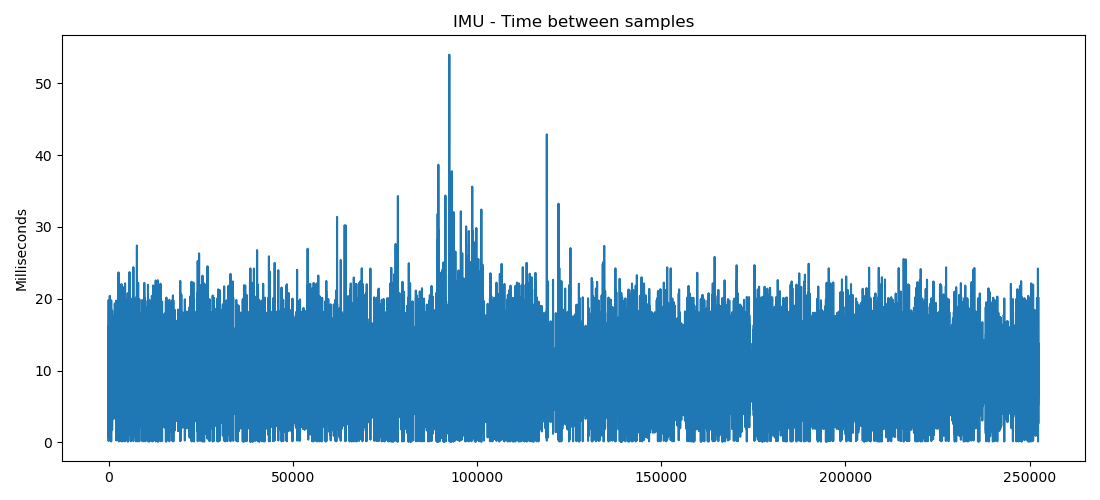

In [26]:
imu_time_diff = imu_time[1:len(imu_time)] - imu_time[0:len(imu_time)-1]

imu_time_fig = plt.figure(1)
imu_time_fig.clear()
plt.plot(1000 * imu_time_diff)
plt.ylabel('Milliseconds')
plt.title('IMU - Time between samples')
imu_time_fig.set_size_inches(11, 5)
imu_time_fig.tight_layout()

plt.show()

## IMU: Time Differences - Histogram

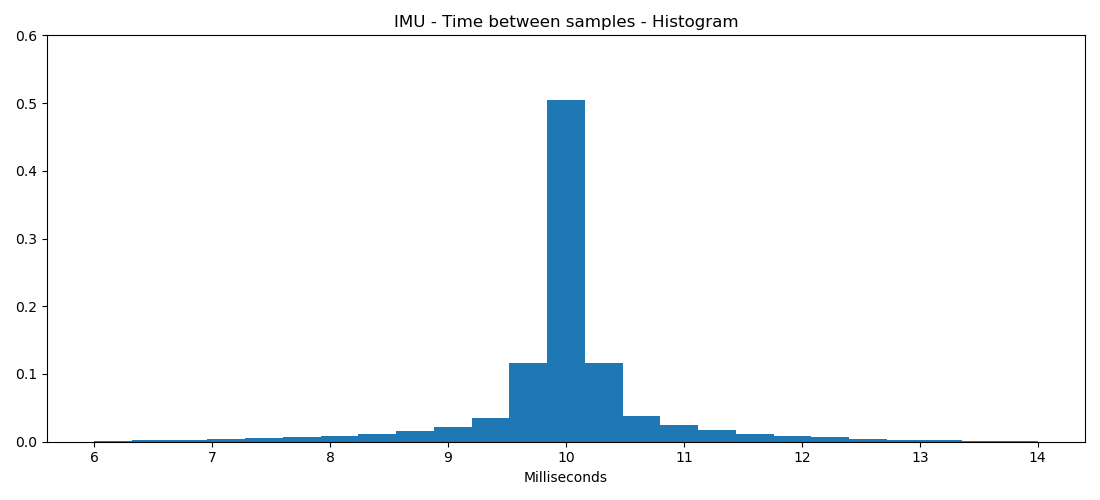

Average: 10.003ms
Std dev: 1.472ms


In [27]:
imu_time_hist = plt.figure(2)
imu_time_hist.clear()
plt.hist(1000 * imu_time_diff, bins=25, range=(6, 14), weights=np.ones_like(imu_time_diff) / len(imu_time_diff))
plt.xlabel('Milliseconds')
plt.ylim(0, 0.6)
plt.title('IMU - Time between samples - Histogram')
imu_time_hist.set_size_inches(11, 5)
imu_time_hist.tight_layout()

plt.show()

print(f'Average: {1000 * np.average(imu_time_diff):.3f}ms\n'
      f'Std dev: {1000 * np.std(imu_time_diff):.3f}ms')

## GPS: Time differences

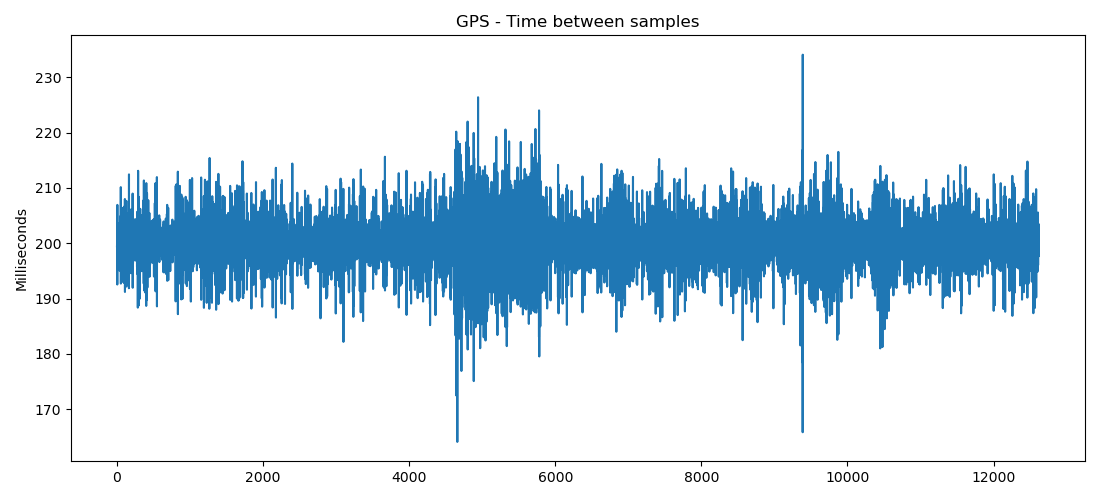

In [28]:
gps_time_diff = gps_time[1:len(gps_time)] - gps_time[0:len(gps_time)-1]

gps_time_fig = plt.figure(3)
gps_time_fig.clear()
plt.plot(1000 * gps_time_diff)
plt.ylabel('Milliseconds')
plt.title('GPS - Time between samples')
gps_time_fig.set_size_inches(11, 5)
gps_time_fig.tight_layout()

plt.show()

## GPS: Time differences - Histogram

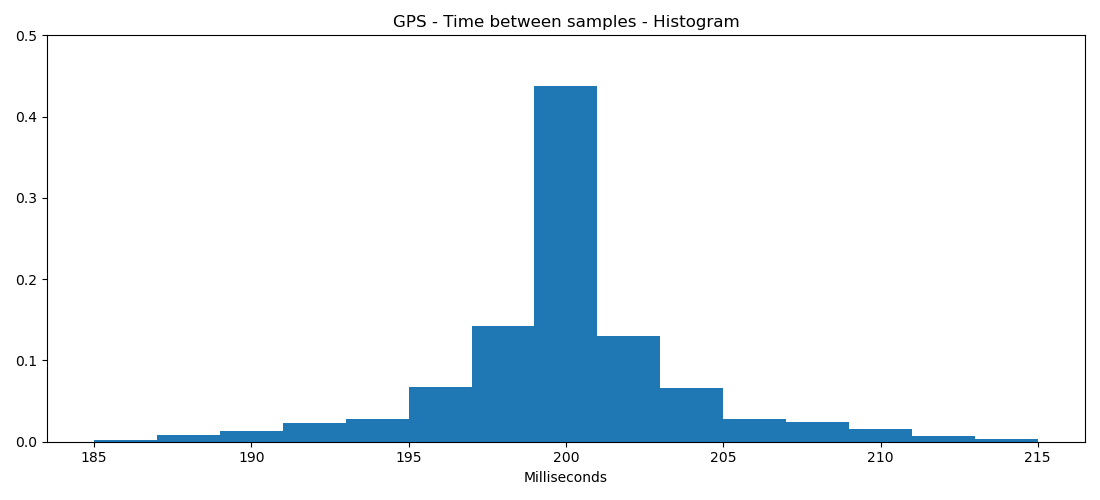

Average: 200.002ms
Std dev: 4.003ms


In [29]:
gps_time_hist = plt.figure(4)
gps_time_hist.clear()
plt.hist(1000 * gps_time_diff, bins=15, range=(185, 215), weights=np.ones_like(gps_time_diff) / len(gps_time_diff))
plt.xlabel('Milliseconds')
plt.ylim(0, 0.5)
plt.title('GPS - Time between samples - Histogram')
gps_time_hist.set_size_inches(11, 5)
gps_time_hist.tight_layout()

plt.show()

print(f'Average: {1000 * np.average(gps_time_diff):.3f}ms\n'
      f'Std dev: {1000 * np.std(gps_time_diff):.3f}ms')

## Sync IMU and GPS data

In [30]:
synced_data = Syncer.transform(wrapped_data, imu_topic, gps_topic, interp_method='cubic_spline')

## IMU: Compare original and synced data

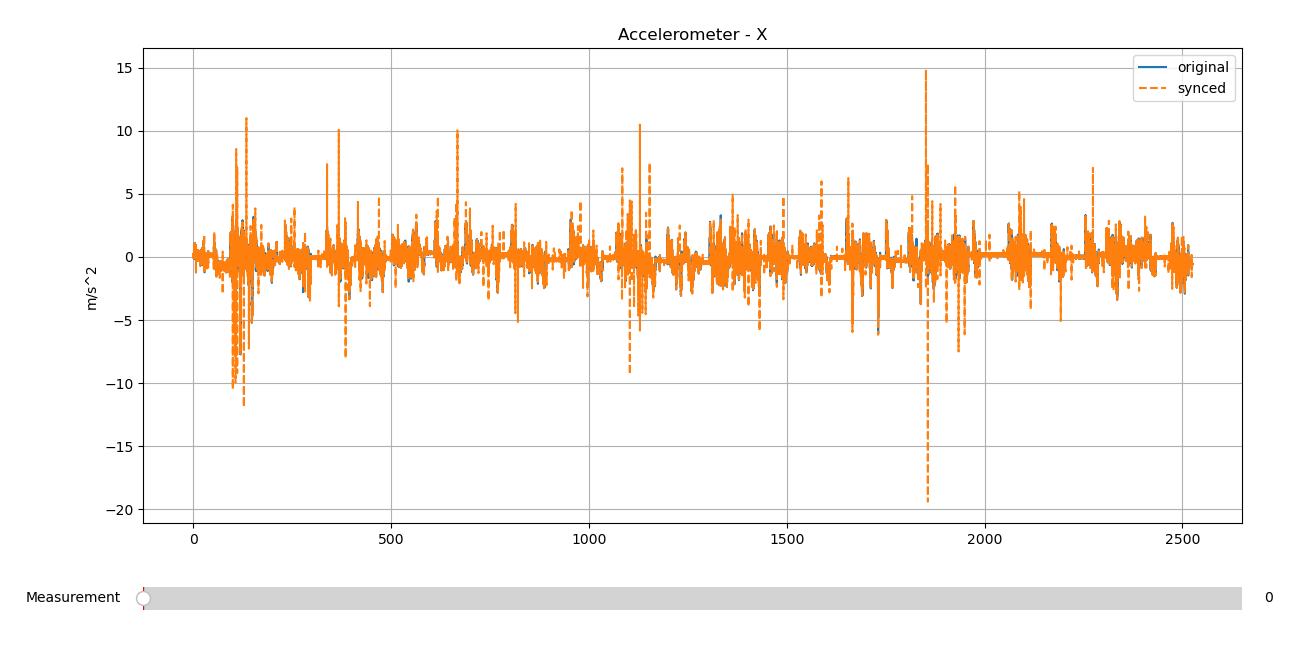

In [31]:
imu_fig = plt.figure(5)
imu_fig.clear()
gs_kw = dict(height_ratios=[1, 0.1])
imu_fig, imu_ax = plt.subplot_mosaic(num=5, mosaic=[['plot'],
                                                    ['slider']], gridspec_kw=gs_kw)

measurement_slider = Slider(ax=imu_ax['slider'], label='Measurement', 
                            valmin=0, 
                            valmax=5, 
                            valinit=0, 
                            valstep=1)

original_data = [a_x, a_y, a_z, g_x, g_y, g_z]
synced_data_path_list = [['accel','x'], ['accel','y'], ['accel','z'], ['gyro','x'], ['gyro','y'], ['gyro','z']]

def change_plot(idx):
    imu_ax['plot'].clear()

    imu_ax['plot'].plot(imu_time, original_data[idx])
    imu_ax['plot'].plot(get_by_path(synced_data, ['time', 'rel']), get_by_path(synced_data, synced_data_path_list[idx]), '--')
    imu_ax['plot'].grid(which='both', axis='both')
    imu_ax['plot'].legend(['original','synced'])

    if idx < 3:
        imu_ax['plot'].set_ylabel('m/s^2')
        measurement = 'Accelerometer'
    else:
        imu_ax['plot'].set_ylabel('rad/s')
        measurement = 'Gyroscope'

    if idx % 3 == 0:
        title = measurement + ' - X'
    elif idx % 3 == 1:
        title = measurement + ' - Y'
    else:
        title = measurement + ' - Z'
    imu_ax['plot'].set_title(title)

change_plot(0)
measurement_slider.on_changed(change_plot)

imu_fig.set_size_inches(13, 6.5)
imu_fig.tight_layout(pad=2.0)

plt.show()

## GPS: Compare original and synced data

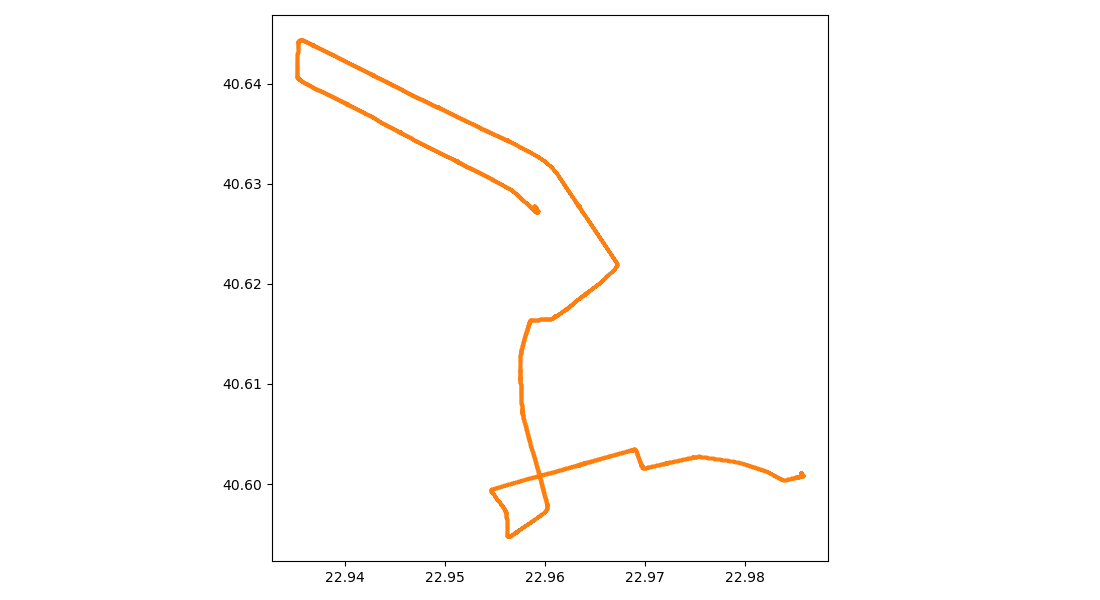

In [32]:
gps_fig = plt.figure(6)
gps_fig.clear()

plt.scatter(synced_data.gps.lon, synced_data.gps.lat, s=0.25)
plt.scatter(lon, lat, s=2)

gps_fig.set_size_inches(11, 6)
gps_fig.gca().set_aspect('equal')
gps_fig.tight_layout()

plt.show()

## GPS Speed: Compare original and synced data

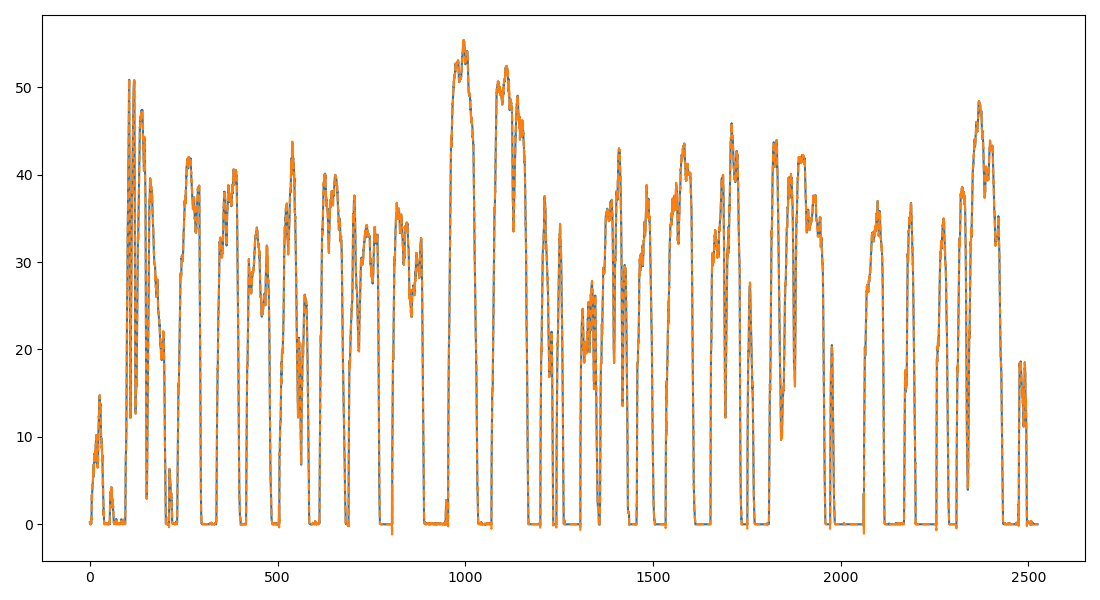

In [33]:
gps_speed_fig = plt.figure(7)
gps_speed_fig.clear()

plt.plot(gps_time, speed)
plt.plot(synced_data['time']['rel'], synced_data['gps']['speed'], '--')

gps_speed_fig.set_size_inches(11, 6)
gps_speed_fig.tight_layout()

plt.show()